

In this notebook, we'll build a convolutional autoencoder to compress the MNIST dataset. Then, we will extend the code to implement a denoising autoencoders. The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://iq.opengenus.org/content/images/2019/03/autoencoder_1.png", width=800, height=200)



## Part I. Load MNIST. Visualize images

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

0it [00:00, ?it/s]

9920512it [00:06, 1602680.79it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 125205.39it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2106632.45it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 47736.84it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


> **Exercise**: Load the data using the DataLoader class ...

In [ ]:

# how many samples per batch to load
batch_size = 128

# prepare data loaders

# Your code here

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

> **Exercise:** Create a validation set with 5000 images

In [ ]:
# Your code here

import copy
validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 
len_data = trainloader.dataset.train_data.shape[0]

#We take all the images except 5000 for training
trainloader.dataset.data = trainloader.dataset.data[:5000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:5000]

#And the rest (5000 images) for validation
validloader.dataset.data = validloader.dataset.data[5000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[5000:]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


> **Exercise:** Complete the following code to visualize an image. What does `np.squeeze()` do?

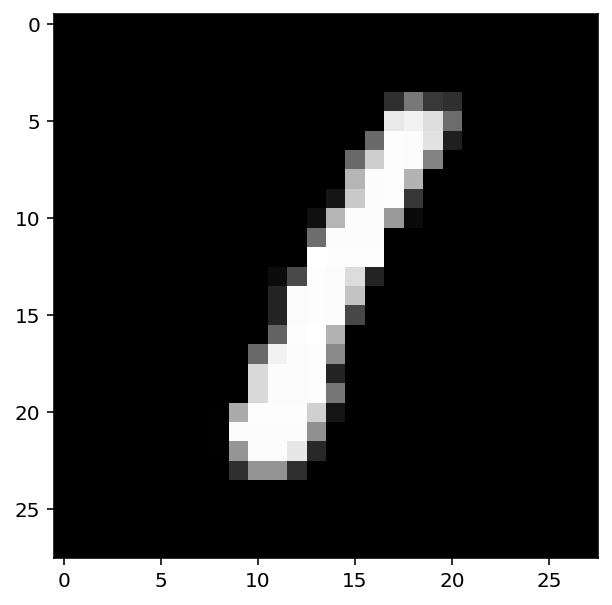

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
    
# obtain one batch of training images
# Your code here
train_iter = iter(trainloader)
images, labels = train_iter.next()
images = images.numpy()

# get one image from the batch
#squeeze output: The input array, but with all or a subset of the dimensions of length 1 removed
img = np.squeeze(images[1])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

What np.squeeze() actually do is to eliminate any axis with size equal to 1

---
## Part II. Create the convolutional  autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

In [ ]:
Image(url= "https://iq.opengenus.org/content/images/2019/03/autoencoder_3.png", width=400, height=200)


Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> **Exercise:** Complete the following code, in which we build the autoencoder using a series of convolutional layers, pooling layers, and transpose convolutional layers. When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [ ]:
import torch.nn as nn
from torch import optim
import time

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## Encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) 
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        # Your code here
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Your code here
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        #latent =  x.view(-1, 4 * (7**2))# compressed representation!!
        #latent =  x.view(-1, 12800)
        latent = x
        # Your code here
        # Decoder
        x = self.t_conv1(x)
        x = self.relu(x)
        x = self.t_conv2(x)
        x = self.sigmoid(x)

        return x,latent

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (sigmoid): Sigmoid()
)


---
## Part III. Training

> **Exercise:** Extend the class implemented above to inlude a training method which monitors the reconstrution loss in both the training and validation datasets. In [this blog](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7) you can find a good summary of Pytorch Loss Functions. For the problem at hand, decide which one is more convenient. 


In [ ]:
class ConvAutoencoder_extended(ConvAutoencoder):
    
    def __init__(self,epochs=100,lr=0.001):
        
        super().__init__() 
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.SmoothL1Loss()
        
        self.loss_during_training = []
        
        self.valid_loss_during_training = []
    
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:

              images = images.to(self.device)

              out, latent = self.forward(images)

              loss = self.criterion(out, images)

              running_loss += loss.item()*images.size(0)
            
              self.optim.zero_grad()

              loss.backward()

              self.optim.step()   

            self.loss_during_training.append(running_loss/len(trainloader))

            valid_loss = 0 
            
            with torch.no_grad():        
              
              self.eval()    

              for images,labels in validloader:
                
                images=images.to(self.device)
                self.optim.zero_grad()

                valid_out,_ = self.forward(images)
                v_loss = self.criterion(valid_out, images)
                valid_loss += v_loss.item()
              
              self.valid_loss_during_training.append(valid_loss/len(validloader))  
              self.train()

            if(e % 1 == 0): # Every 10 epochs
              print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                    %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                      (time.time() - start_time)))                

> **Exercise:** Train the model for 10 epochs and plot both training and validation losses. Can you visualize overfitting?

In [ ]:
# Your code here

my_autoencoder = ConvAutoencoder_extended(epochs=10,lr=1e-3)
print(my_autoencoder)

my_autoencoder.trainloop(trainloader,validloader)

ConvAutoencoder_extended(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (sigmoid): Sigmoid()
  (criterion): SmoothL1Loss()
)
Epoch 0. Training loss: 16.317693, Validation loss: 0.119048, Time per epoch: 24.821814 seconds
Epoch 1. Training loss: 12.274448, Validation loss: 0.074254, Time per epoch: 23.461591 seconds
Epoch 2. Training loss: 6.813861, Validation loss: 0.035955, Time per epoch: 21.585312 seconds
Epoch 3. Training loss: 3.637974, Validation loss: 0.025200, Time per epoch: 21.211921 seconds
Epoch 4. Training loss: 2.975291, Validation loss: 0.022592, Time per epoch: 23.374534 seconds
Epoch 5. Training loss: 2.655657, Validation l

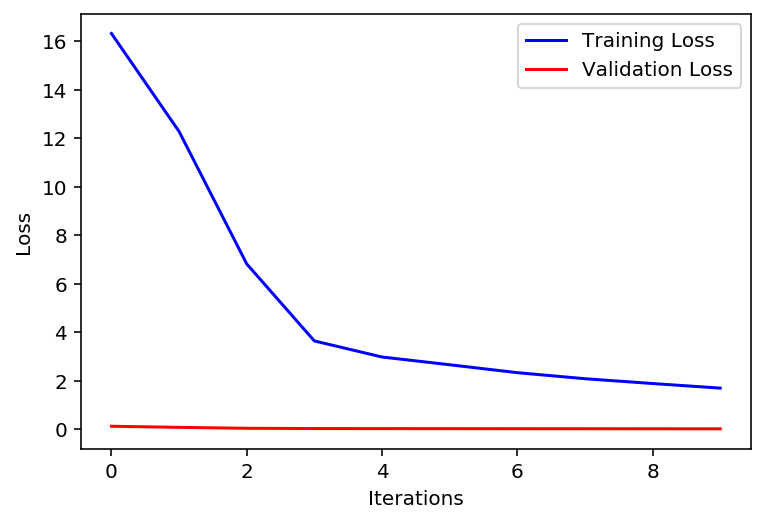

In [ ]:
# Your code here

plt.plot(my_autoencoder.loss_during_training,'-b',label='Training Loss')
plt.plot(my_autoencoder.valid_loss_during_training,'-r',label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

We cannot visualize overfitting since the validation error is really small compared to the training error.

### Checking out the results

Below we plot some of the **test images** along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

> **Exercise:** Complete the code (just one line!)

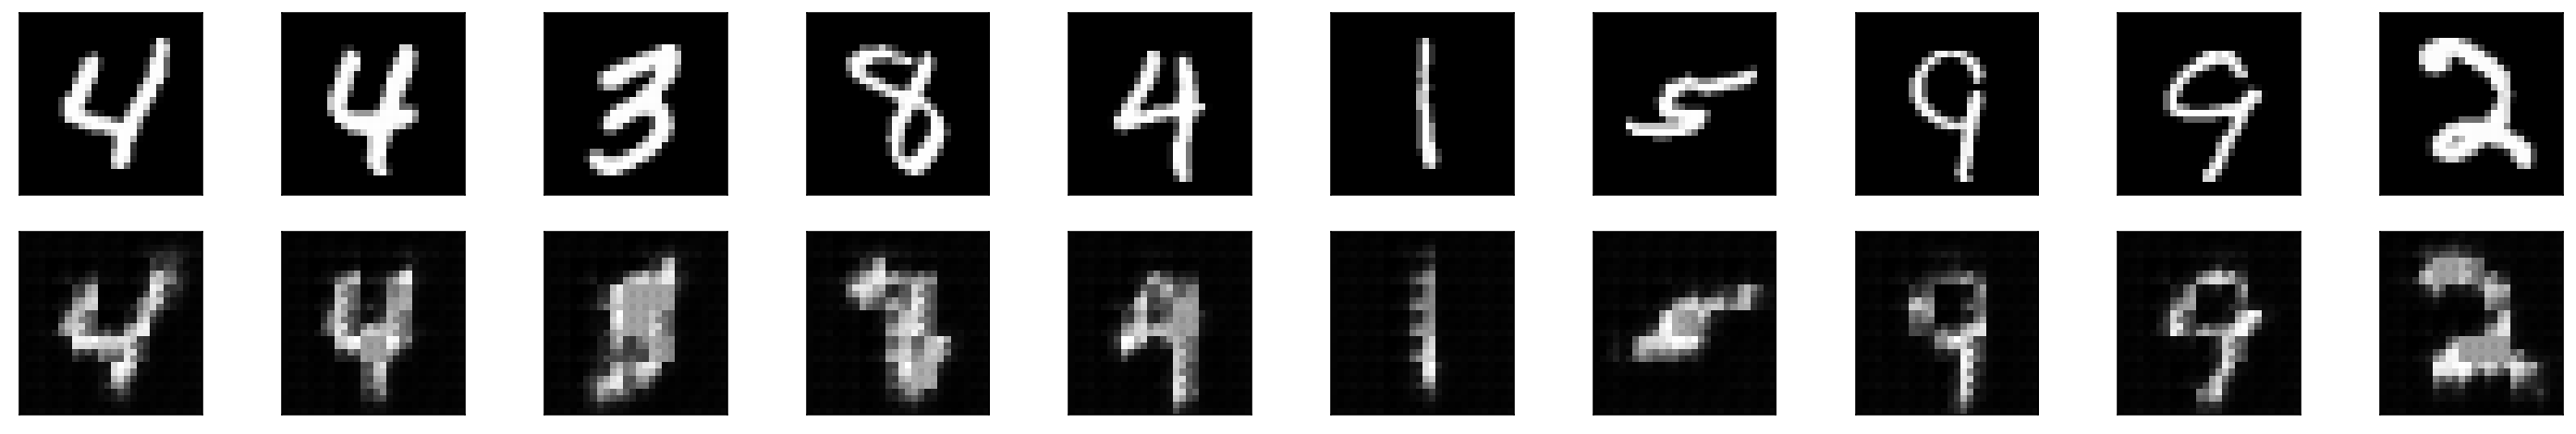

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample output

#Your code here
output,latent = my_autoencoder(images)          
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    axes[0,i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[1,i].imshow(np.squeeze(output[i]), cmap='gray')

    axes[0,i].get_xaxis().set_visible(False) # Remove legend
    axes[0,i].get_yaxis().set_visible(False)
    axes[1,i].get_xaxis().set_visible(False) # Remove legend
    axes[1,i].get_yaxis().set_visible(False)    
    

## Part IV. Projecting the images in a 2 dimensional space

The results are actually not bad at all!! Now, we are going to project the images in a space of only 2 dimensions (instead of `7x7x4=196`). Obviously, we expect **much worse** reconstruction quality. However, in this case we are indeed interested in the structure of the projected space (i.e. how the autoencoder organizes the images in the 2D latent space). Since reconstruction quality is not our goal, we will implement both the encoder and the decoder using only **two dense layers each**. 

> **Exercise:** 
> - Implement the described autoencoder. Use **hiperbolic tangent** activation functions. For shuch a small network, a `ReLU` does not provide good results. 
>
> - Extend the class to incorporate the training loop and the evaluation of the loss function in the validation set during training
> 
> - Train the model a few times and select the one that provides the best results (sometimes you will see the solution gets stuck in a very bad local optima). To do so, **create 10 objects of the same type, train each of them independently for 50 epochs, and finally select the one that provides the smallest validation loss**. 
>
>- For the selected model, compute the encoder's latent representation in the 2D space for a mini-batch of images and visualize 2D projections using the following function:

```python

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_latent_space_with_images(images,latent):
    
    # images --> Minibatch of images (numpy array!)
    # laent --> Matrix of 2D representations (numpy array!)
    
    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(np.squeeze(images[i]), cmap='gray')
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title('Latent space Z with Images')

```





In [ ]:
class ConvAutoencoder2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(28,14)
        
        self.linear2 = nn.Linear(14,7)

        self.inverseLinear2 = nn.Linear(7,14)
        
        self.inverseLinear1 = nn.Linear(14,28)

        self.tanh = nn.Tanh()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        latent = self.tanh(x)

        x = self.inverseLinear2(latent)
        x = self.tanh(x)
        x = self.inverseLinear1(x)
        x = self.sigmoid(x)

        return x, latent


In [ ]:
class ConvAutoencoder2D_extended(ConvAutoencoder2D):
    
    def __init__(self,epochs=100,lr=0.001):
        
        super().__init__() 
        self.lr = lr     
        self.optim = optim.Adam(self.parameters(), self.lr)      
        self.epochs = epochs
        self.criterion = nn.SmoothL1Loss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            start_time = time.time()       
            running_loss = 0.        
            for images, labels in trainloader:
              images = images.to(self.device)
              out, latent = self.forward(images)
              loss = self.criterion(out, images)
              running_loss += loss.item()*images.size(0)          
              self.optim.zero_grad()
              loss.backward()
              self.optim.step()   
            self.loss_during_training.append(running_loss/len(trainloader))
            valid_loss = 0          
            with torch.no_grad():            
              self.eval()    
              for images,labels in validloader:               
                images=images.to(self.device)
                self.optim.zero_grad()
                valid_out,_ = self.forward(images)
                v_loss = self.criterion(valid_out, images)
                valid_loss += v_loss.item()             
              self.valid_loss_during_training.append(valid_loss/len(validloader))  
              self.train()
            if(e % 10 == 0): # Every 10 epochs
              print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                    %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                      (time.time() - start_time))) 

In [ ]:
valid_loss_list = []

for i in range(10):
  print('----')
  print('Model ', i+1)
  my_autoencoder_2D = ConvAutoencoder2D_extended(epochs=50,lr=1e-3)
  my_autoencoder_2D.trainloop(trainloader, validloader)

  valid_loss_list.append(my_autoencoder_2D.valid_loss_during_training[-1])
  if(valid_loss_list[i] < valid_loss_list[i-1]):
        best_model = my_autoencoder_2D
        
num_best_model = np.argmin(valid_loss_list)
print('The best model is:'+str(num_best_model))



----
Model  1
Epoch 0. Training loss: 14.180207, Validation loss: 0.102727, Time per epoch: 5.181826 seconds
Epoch 10. Training loss: 3.568056, Validation loss: 0.027709, Time per epoch: 4.784514 seconds
Epoch 20. Training loss: 2.166240, Validation loss: 0.016910, Time per epoch: 5.114430 seconds
Epoch 30. Training loss: 1.540100, Validation loss: 0.012224, Time per epoch: 4.852467 seconds
Epoch 40. Training loss: 1.286766, Validation loss: 0.010251, Time per epoch: 4.973405 seconds
----
Model  2
Epoch 0. Training loss: 13.974759, Validation loss: 0.100726, Time per epoch: 4.895842 seconds
Epoch 10. Training loss: 3.934955, Validation loss: 0.030178, Time per epoch: 5.179993 seconds
Epoch 20. Training loss: 2.669171, Validation loss: 0.021056, Time per epoch: 4.904420 seconds
Epoch 30. Training loss: 2.325957, Validation loss: 0.018528, Time per epoch: 5.131727 seconds
Epoch 40. Training loss: 1.496293, Validation loss: 0.011594, Time per epoch: 4.888160 seconds
----
Model  3
Epoch 0.

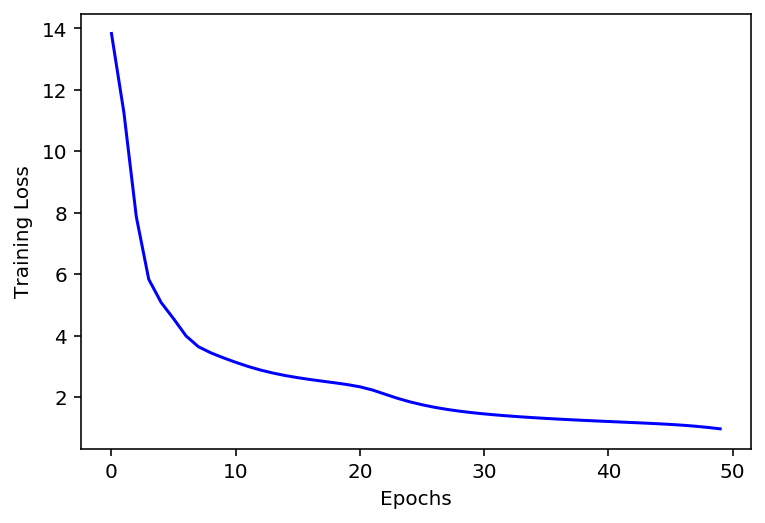

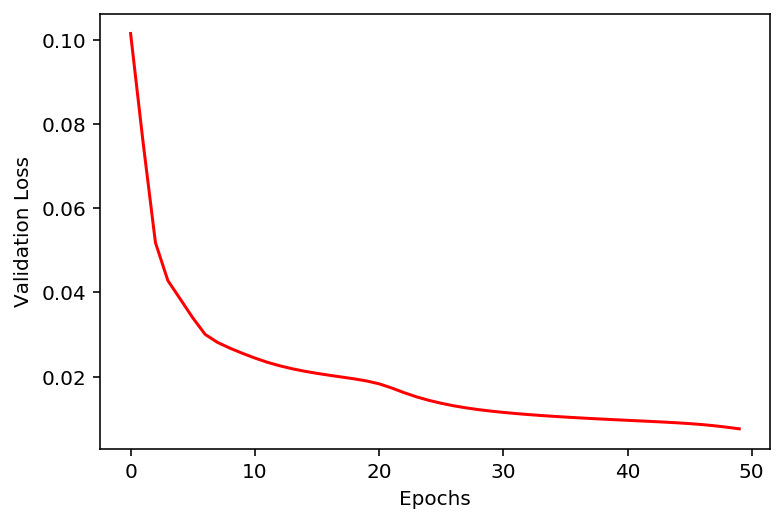

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_model.loss_during_training,'b')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()




plt.plot(best_model.valid_loss_during_training,'r')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()




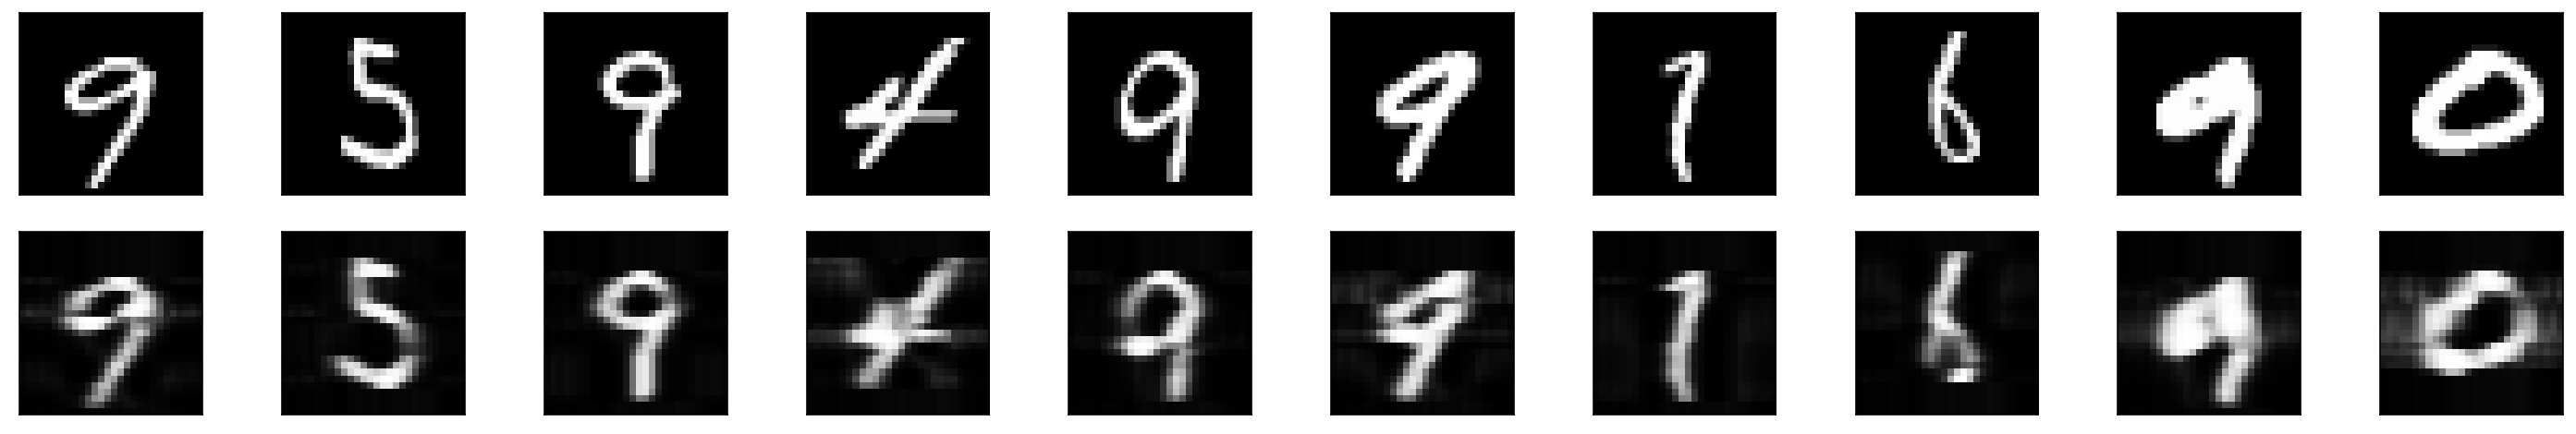

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output,latent = best_model(images)       
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    axes[0,i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[1,i].imshow(np.squeeze(output[i]), cmap='gray')

    axes[0,i].get_xaxis().set_visible(False) # Remove legend
    axes[0,i].get_yaxis().set_visible(False)
    axes[1,i].get_xaxis().set_visible(False) # Remove legend
    axes[1,i].get_yaxis().set_visible(False)    
    